<a href="https://colab.research.google.com/github/smn-mndl/Datascience-Projects/blob/main/M22AI648_DLAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
#import base pre-trained model
from keras.applications import VGG16
modelvgg16 = VGG16(include_top=True,weights='imagenet')
modelvgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [200]:
#remove the last layer(prediction layer)
from keras import models
modelvgg = models.Model(inputs  =  modelvgg16.inputs,
                        outputs = modelvgg16.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [201]:
image_dir = '/content/drive/MyDrive/Project Files/DLAssignment/Untitledfolder/VOCdevkit/VOC2007/JPEGImages'
annotations_dir = '/content/drive/MyDrive/Project Files/DLAssignment/Untitledfolder/VOCdevkit/VOC2007/Annotations'

In [202]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

In [203]:
#find features and labels from given data
features = []
labels = []
image_files = os.listdir(image_dir)
image_files = image_files[:1000]
for image_name in image_files:
  #load and preprocess the image
  img_path = os.path.join(image_dir,image_name)
  img = image.load_img(img_path, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  #extract features using a pre trained model
  img_features = modelvgg.predict(img)
  features.append(img_features)

  #extract class labels from the annotations
  annotation_file = image_name.split('.')[0] + '.xml'
  annotation_path = os.path.join(annotations_dir,annotation_file)

  #parse xml annotation file
  tree = ET.parse(annotation_path)
  root = tree.getroot()

  #find the class label
  class_labels = []
  for obj in root.findall('object'):
    class_label = obj.find('name').text
    class_labels.append(class_label)
  labels.append(class_labels)

1/1 [==============================] - 1s 982ms/step


In [204]:
#convert features and labels to numpy array
features = np.vstack(features)
labels = np.array(labels, dtype=object)

In [205]:
#multi level binarization on the labels to transform the classes into  binaries
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

In [206]:
mlb.classes_

array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype=object)

In [207]:
#Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size = 0.3, random_state=42)

In [208]:
train_labels.shape

(700, 20)

In [209]:
val_labels.shape

(300, 20)

In [210]:
classifiers = {}
for class_index in range(train_labels.shape[1]):
  #prepare the training data
  class_train_labels = train_labels[:,class_index]
  svm = SVC()
  svm.fit(train_features, class_train_labels)

  #save the trained classifier
  classifiers[mlb.classes_[class_index]] = svm

In [211]:
#evaluate the classifier on validation data
class_details = []

for class_index in range(val_labels.shape[1]):
  each_class = {}
  class_val_labels = val_labels[:,class_index]

  #predict labels using trained classifier
  current_classifier = classifiers[mlb.classes_[class_index]]
  predicted_labels = current_classifier.predict(val_features)

  #get accuracy by comparing predicted and class labels and round up to 2 decimal
  accuracy = round(np.mean(predicted_labels == class_val_labels)*100, 2)

  #determine confusion matrix for current class
  confusion_matrix = metrics.confusion_matrix(class_val_labels, predicted_labels)

  each_class['class'] = mlb.classes_[class_index]
  each_class['accuracy'] = accuracy
  each_class['confusion_matrix'] = confusion_matrix

  class_details.append(each_class)


In [212]:
def draw_confusion_matrix(confusion_matrix):
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  cm_display.plot()
  plt.ylabel('Prediction',fontsize=13)
  plt.xlabel('Actual',fontsize=13)
  plt.title('Confusion Matrix',fontsize=13)
  plt.show()

Class Name:  aeroplane , Accuracy:  99.67 % , Confusion Matrix:  [[299   0]
 [  1   0]]


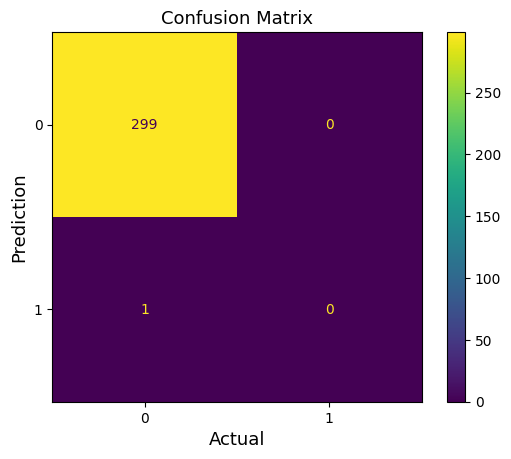



Class Name:  bicycle , Accuracy:  98.33 % , Confusion Matrix:  [[282   0]
 [  5  13]]


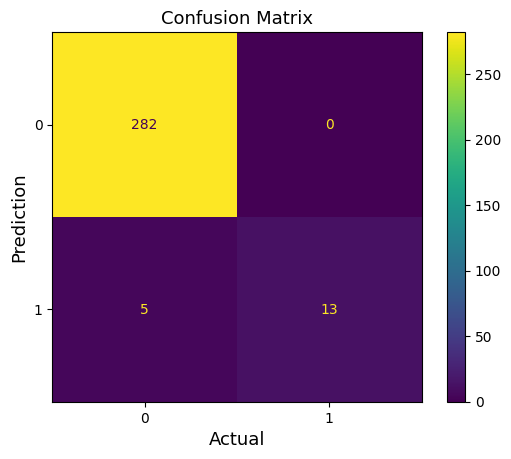



Class Name:  bird , Accuracy:  97.0 % , Confusion Matrix:  [[291   0]
 [  9   0]]


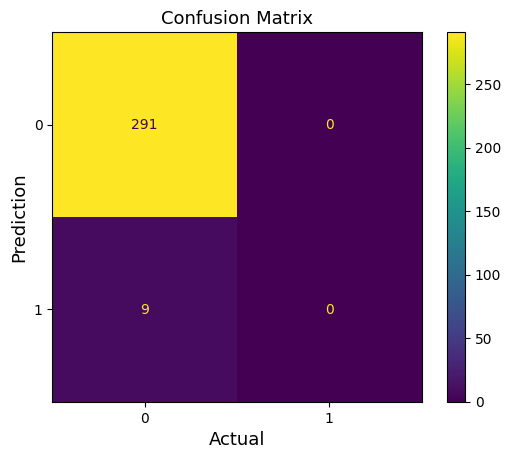



Class Name:  boat , Accuracy:  99.0 % , Confusion Matrix:  [[273   1]
 [  2  24]]


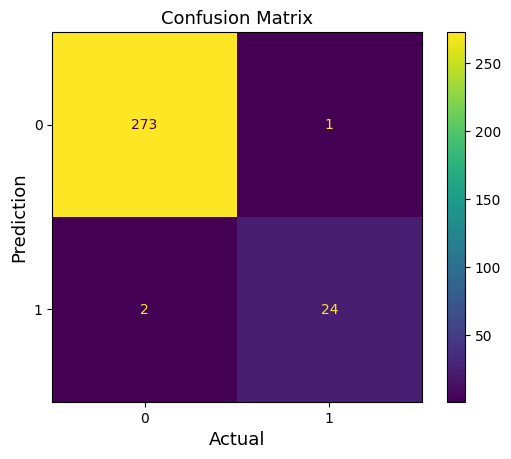



Class Name:  bottle , Accuracy:  94.33 % , Confusion Matrix:  [[281   0]
 [ 17   2]]


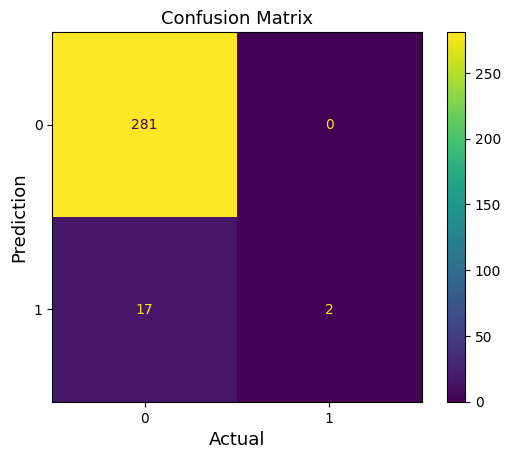



Class Name:  bus , Accuracy:  96.33 % , Confusion Matrix:  [[287   0]
 [ 11   2]]


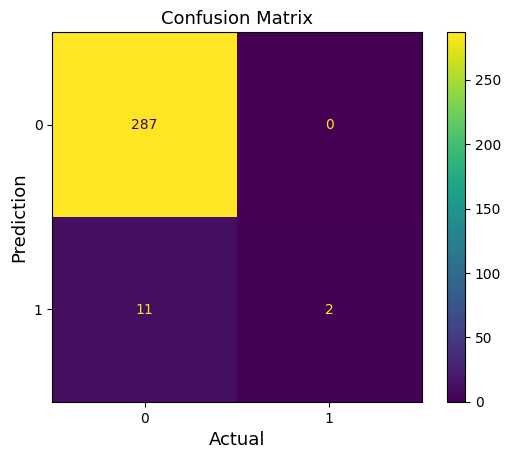



Class Name:  car , Accuracy:  93.0 % , Confusion Matrix:  [[258   7]
 [ 14  21]]


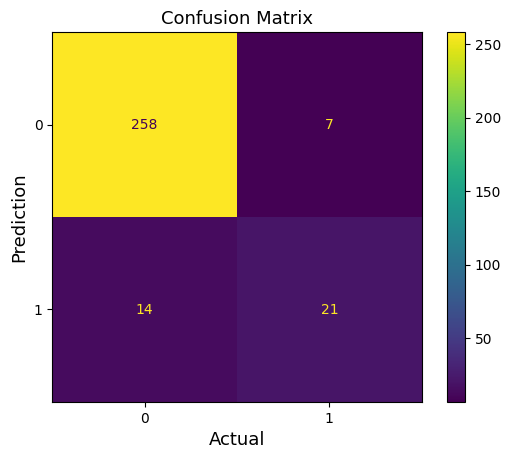



Class Name:  cat , Accuracy:  97.0 % , Confusion Matrix:  [[278   0]
 [  9  13]]


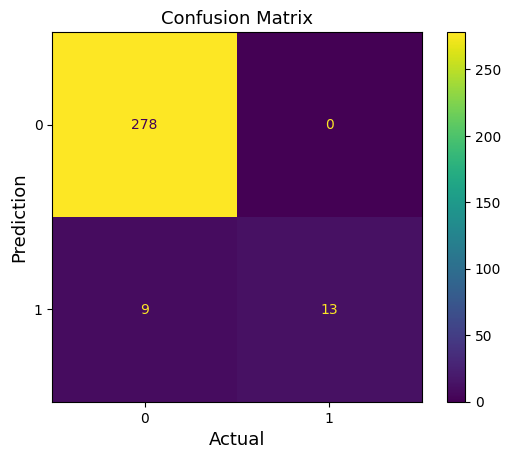



Class Name:  chair , Accuracy:  91.0 % , Confusion Matrix:  [[256  10]
 [ 17  17]]


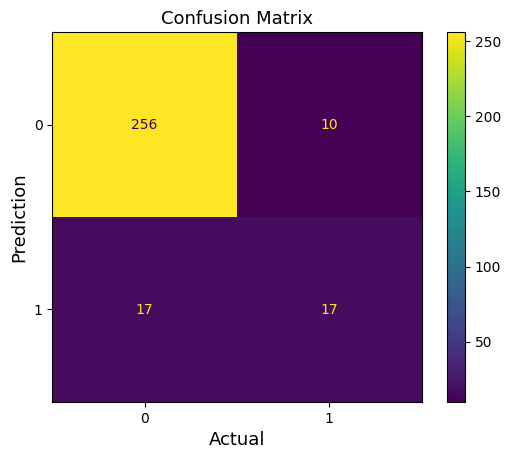



Class Name:  cow , Accuracy:  99.67 % , Confusion Matrix:  [[299   0]
 [  1   0]]


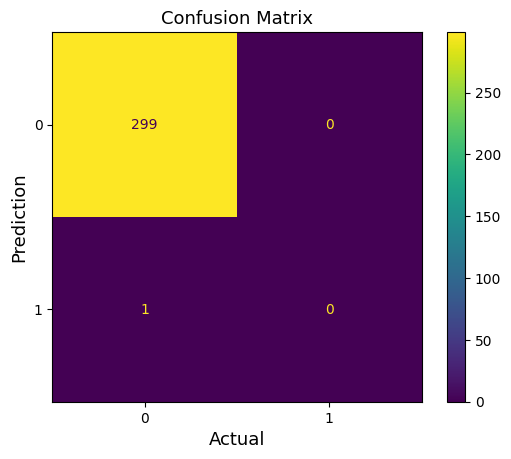



Class Name:  diningtable , Accuracy:  95.67 % , Confusion Matrix:  [[281   0]
 [ 13   6]]


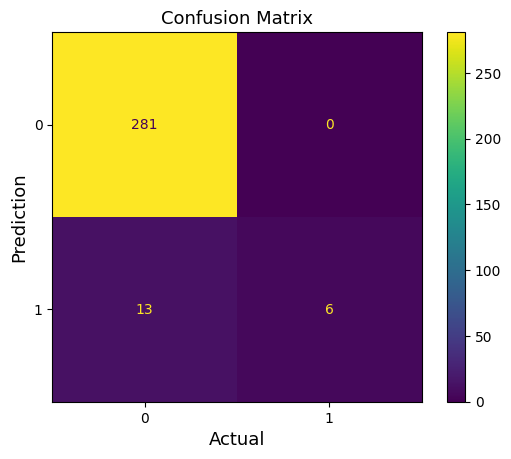



Class Name:  dog , Accuracy:  96.67 % , Confusion Matrix:  [[290   0]
 [ 10   0]]


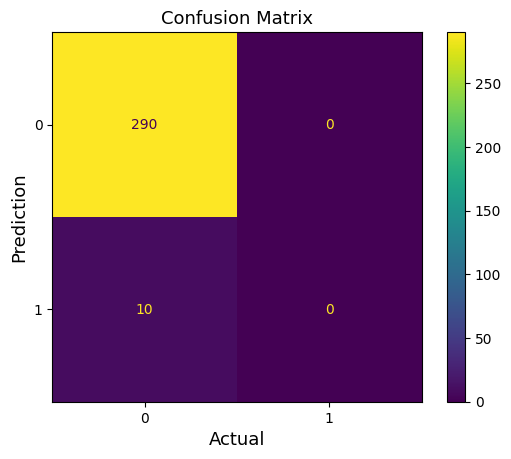



Class Name:  horse , Accuracy:  98.33 % , Confusion Matrix:  [[295   0]
 [  5   0]]


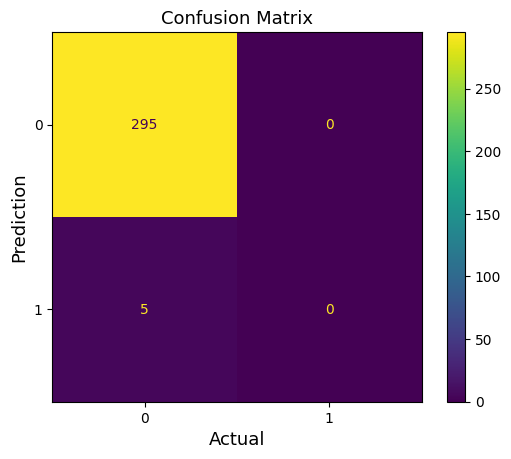



Class Name:  motorbike , Accuracy:  95.0 % , Confusion Matrix:  [[271   2]
 [ 13  14]]


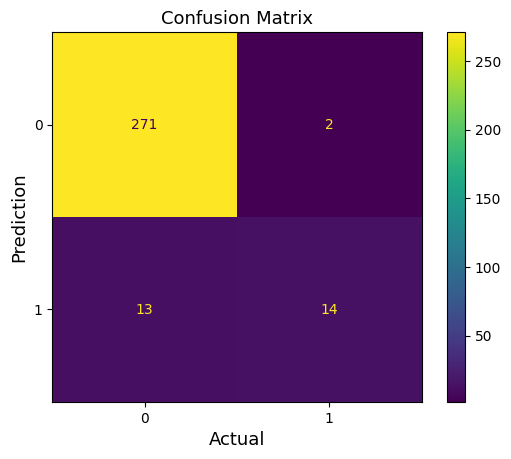



Class Name:  person , Accuracy:  82.67 % , Confusion Matrix:  [[157   2]
 [ 50  91]]


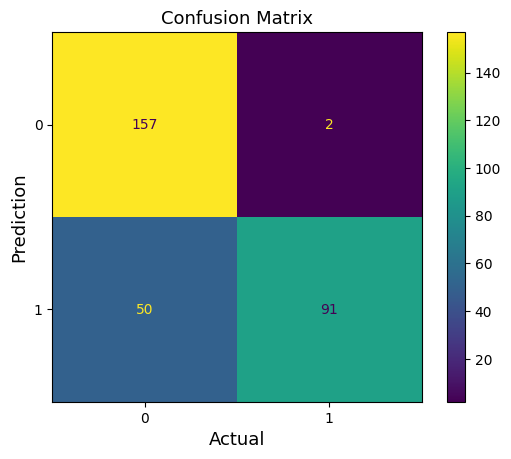



Class Name:  pottedplant , Accuracy:  93.0 % , Confusion Matrix:  [[279   0]
 [ 21   0]]


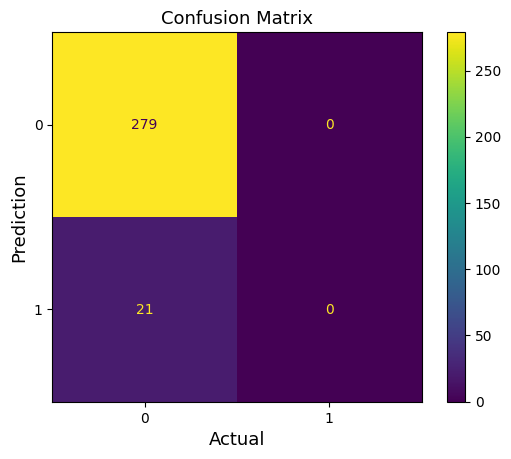



Class Name:  sheep , Accuracy:  99.0 % , Confusion Matrix:  [[290   0]
 [  3   7]]


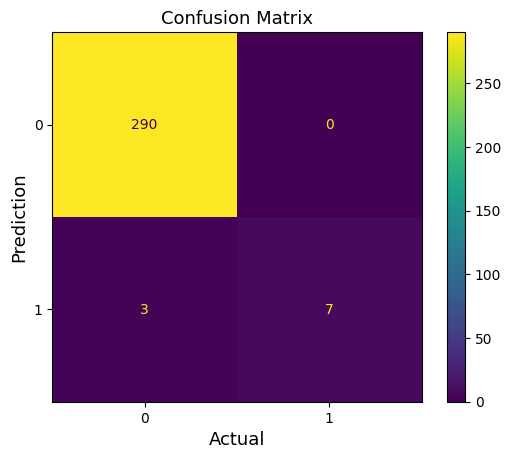



Class Name:  sofa , Accuracy:  94.67 % , Confusion Matrix:  [[270   2]
 [ 14  14]]


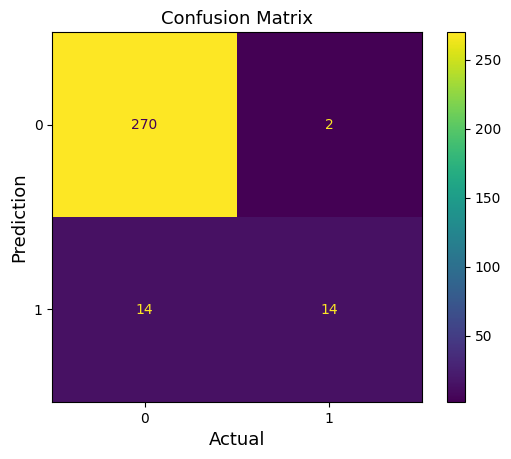



Class Name:  train , Accuracy:  99.0 % , Confusion Matrix:  [[265   0]
 [  3  32]]


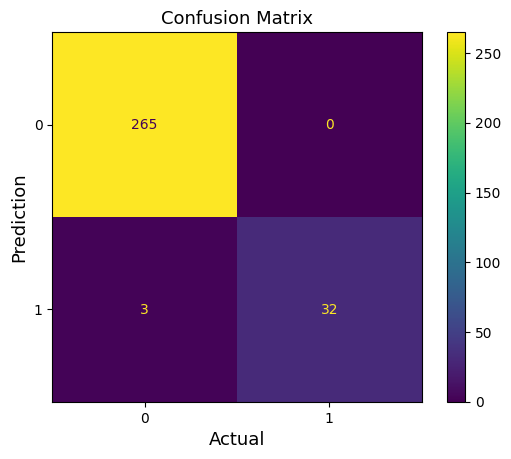



Class Name:  tvmonitor , Accuracy:  96.0 % , Confusion Matrix:  [[288   1]
 [ 11   0]]


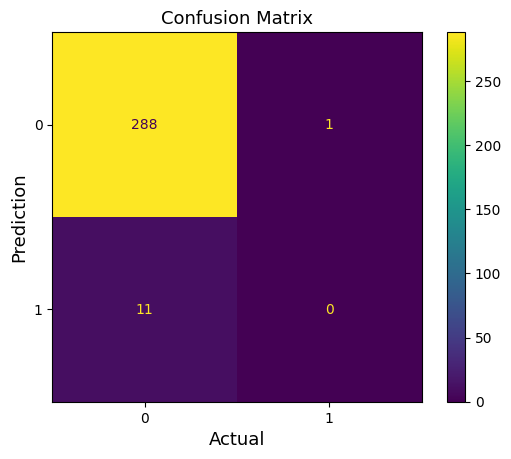

In [213]:
for i in class_details:
  print('Class Name: ', i['class'],',', 'Accuracy: ', i['accuracy'],'%', ',','Confusion Matrix: ', i['confusion_matrix'])
  draw_confusion_matrix(i['confusion_matrix'])
  print('\n')